# HIPAA Privacy Rule-based De-identification on DICOM Dataset

HIPAA provides two methods for de-identification: the "Safe Harbor" method and the "Expert Determination" method. The Safe Harbor method is more straightforward and involves anonymizing/redacting 18 specific types of identifiers from the data.

Here, we will focus on the Safe Harbor method, which includes removing or redacting identifiers such as names, geographic subdivisions smaller than a state, dates directly related to an individual, phone numbers, email addresses, and more.

After de-ID,  the DICOM file will be updated and uploaded to destiny storage and evaluated by AWS services, Rekongnition, Comprehend and Comprehend Medical.

## Setup De-identification Environment

Let's start by setting environment variables for de identification of DICOM file:
1) set local path of DICOM img folder.
2) set source and destiny s3 bucket.
3) set source and destiny prefix for DICOM file.
4) cleanup de-id DICOM dir and evaluation DICOM dir
5) set aws session with user profile name.

In [1]:
from med_img_de_id_class import ProcessMedImage
from common.utils import get_boto3_session, draw_img, dump_dict_to_tsv, dump_object_to_text
# setup environment
LOC_DICOM_FOLDER = '../images/med_phi_img/'
LOC_DE_ID_DICOM_FOLDER = '../images/med_de_id_img/'
LOC_EVAL_DICOM_FOLDER = '../images/med_eval_img/'
SOURCE_BUCKET = "de-id-src"
DESTINATION_BUCKET = "de-id-dst"
SOURCE_PREFIX = "dicom-images/"
DESTINATION_PREFIX = "de-id-dicom-images/"
EVAL_BUCKET = "de-id-evl"
EVAL_PREFIX = "eval-de-id-dicom-images/"

aws_session = get_boto3_session("esi")
rule_config_file_path= '../configs/de-id/de_id_rules_auto.yaml'

processor = ProcessMedImage(aws_session, rule_config_file_path)

## Parse DICOM Image

In [2]:
# local_img_file = "1-053.dcm" 
# local_img_file ="RiveraMichael.dcm"
# local_img_file = "MeyerStephanie.dcm"
# local_img_file = "hefe.dcm"
# local_img_file = "TeFain.dcm"
# local_img_file = 'MartinChad-1-1.dcm'
# local_img_file = 'ScottKauf-Man.dcm'
# local_img_file = '1-043.dcm'
# local_img_file = 'lung-1-1.dcm'
# local_img_file = "DavidsonDouglas.dcm"
# local_img_file = "00002024.dcm"
# local_img_file = "00000044.dcm"
local_img_file = "00000001.dcm"
# local_img_file = "00000027.dcm"
local_img_path = LOC_DICOM_FOLDER + local_img_file
src_key= SOURCE_PREFIX + local_img_file
dist_key= DESTINATION_PREFIX + local_img_file
result = processor.parse_dicom_file(None, None, local_img_path)

number_of_frames: 1
min_pixel: 0, max_pixel: 4095


## De-Identification in Metadata of DICOM

In [3]:
# dump tags before De-id
dump_object_to_text(processor.ds, '../temp/ds_before_de_id.txt')
processor.de_identify_dicom()

De-identifying DICOM metadata
Tag: (0008, 0016) SOP Class UID                       UI: Digital X-Ray Image Storage - For Presentation - Redacted Value: 1.2.826.0.1.3680043.8.498.93309449797502401120550241058771153076
Tag: (0008, 0018) SOP Instance UID                    UI: 2.1.497.0.0.1835643.9.081.1190820140911593291 - Redacted Value: 1.2.826.0.1.3680043.8.498.70903844714426805757501069822848644223
Tag: (0008, 0020) Study Date                          DA: '20181213' - Redacted Value: 00010101
Tag: (0008, 0021) Series Date                         DA: '20181213' - Redacted Value: 00010101
Tag: (0008, 0022) Acquisition Date                    DA: '20181213' - Redacted Value: 00010101
Tag: (0008, 0023) Content Date                        DA: '20181213' - Redacted Value: 00010101
Tag: (0008, 0030) Study Time                          TM: '153251' - Redacted Value: 000000.00
Tag: (0008, 0031) Series Time                         TM: '153318' - Redacted Value: 000000.00
Tag: (0008, 0032) Acq

/Users/gup2/workspace/vscode/crdcdh/crdcdh-de-id-notebook/.venv/lib/python3.12/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '2.1.497.0.0.1835643.9.081.1190820140911593291'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/Users/gup2/workspace/vscode/crdcdh/crdcdh-de-id-notebook/.venv/lib/python3.12/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '2.1.497.0.0.1835643.9.081.3351050814573364178'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
/Users/gup2/workspace/vscode/crdcdh/crdcdh-de-id-notebook/.venv/lib/python3.12/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '2.1.497.0.0.1835643.9.081.1307210876115091140'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-

(31,
 [(8, 22),
  (8, 24),
  (8, 32),
  (8, 33),
  (8, 34),
  (8, 35),
  (8, 48),
  (8, 49),
  (8, 50),
  (8, 51),
  (8, 80),
  (8, 144),
  (8, 4144),
  (8, 4158),
  (16, 16),
  (16, 32),
  (16, 48),
  (16, 64),
  (16, 4112),
  (16, 4128),
  (16, 4144),
  (24, 4128),
  (24, 28684),
  (24, 28686),
  (32, 13),
  (32, 14),
  (40, 4160),
  (40, 4180),
  (64, 5120),
  (64, 9216),
  (64, 41077)])

## Draw DICOM Image Before De-identification

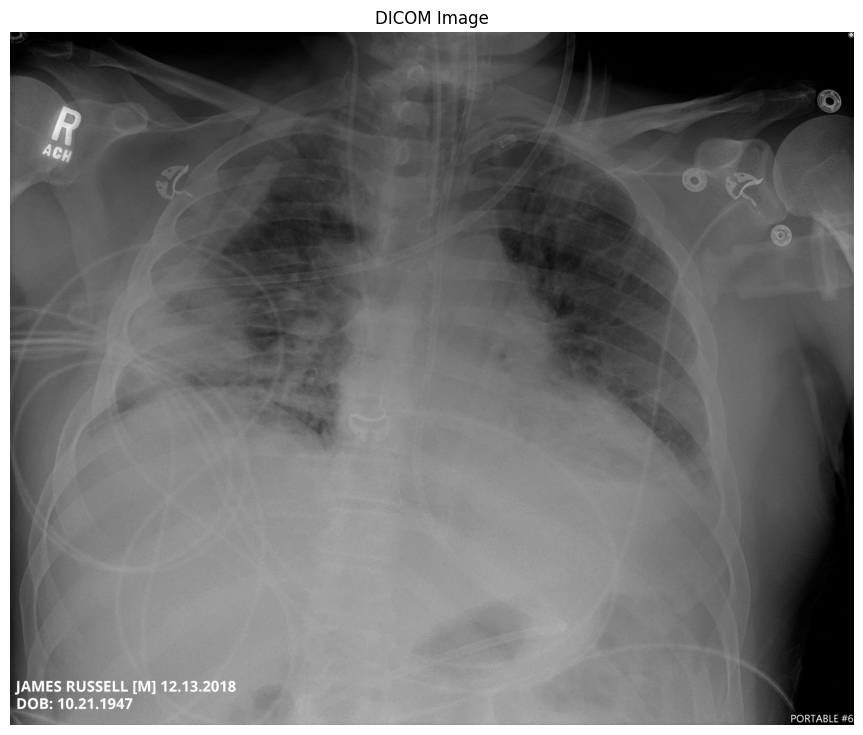

In [4]:
# show med image before de-identification
draw_img(processor.image_data)

## De-identification in pixel of DICOM

In [5]:
id_text_detected, text_detected = processor.detect_id_in_img(None, None)
if id_text_detected and len(id_text_detected):
    print(f'Sensitive text detected in {local_img_file}')
    print (id_text_detected)
    processor.redact_id_in_image(id_text_detected)
    print('Sensitive text in image have been redacted')

else:
    print(f'No sensitive text detected in {local_img_file}')


Detected Text in pixel data: fps at line: 1 with confidence 26.
Detected Text in pixel data: teks at line: 1 with confidence 12.
Detected Text in pixel data: PORTABLE at line: 2 with confidence 96.
Detected Text in pixel data: #6 at line: 3 with confidence 95.
Line 0: 'fps' at (1476, 769, 13, 13)
Line 1: 'teks' at (1476, 747, 13, 18)
Line 2: 'PORTABLE #6' at (3155, 2759, 249, 30)
Sensitive text detected in 00000001.dcm
[{'Text': 'fps', 'Text Block': {'Left': 1476, 'Top': 769, 'Width': 13, 'Height': 13}}]
Sensitive text in image have been redacted


## Updated the DICOM with redacted metadata and blurred sensitive identification text in image.

In [6]:
import os
local_de_id_dicom_dir = f"{LOC_DE_ID_DICOM_FOLDER}test/{processor.patient_id}/{processor.studyInstanceUID}/{processor.seriesInstanceUID}/"
if not os.path.exists(local_de_id_dicom_dir):
    os.makedirs(local_de_id_dicom_dir)
local_de_id_dicom = os.path.join(local_de_id_dicom_dir, local_img_file )
processor.save_de_id_dicom(local_de_id_dicom)

DICOM file has been saved to ../images/med_de_id_img/test/patient^0183/1.2.826.0.1.3680043.8.498.12372289320255216260030039034645098873/1.2.826.0.1.3680043.8.498.39192757444426073927643210240319308820/00000001.dcm.


## Parse redacted DICOM for evaluation with AWS Comprehend and Comprehend Medical

In [7]:
src_key = DESTINATION_PREFIX + local_img_file.replace("dcm", "png")
dist_key= EVAL_PREFIX + local_img_file 
result = processor.parse_dicom_file(DESTINATION_BUCKET, src_key, local_de_id_dicom, True)

number_of_frames: 1
min_pixel: 0, max_pixel: 4095


# Show Image and Metadata in De-id DICOM File Before Evaluation

/Users/gup2/workspace/vscode/crdcdh/crdcdh-de-id-notebook/.venv/lib/python3.12/site-packages/pydicom/valuerep.py:443: UserWarning: Invalid value for VR UI: '2.1.497.0.0.1835643.9.081.1190820140911593291'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


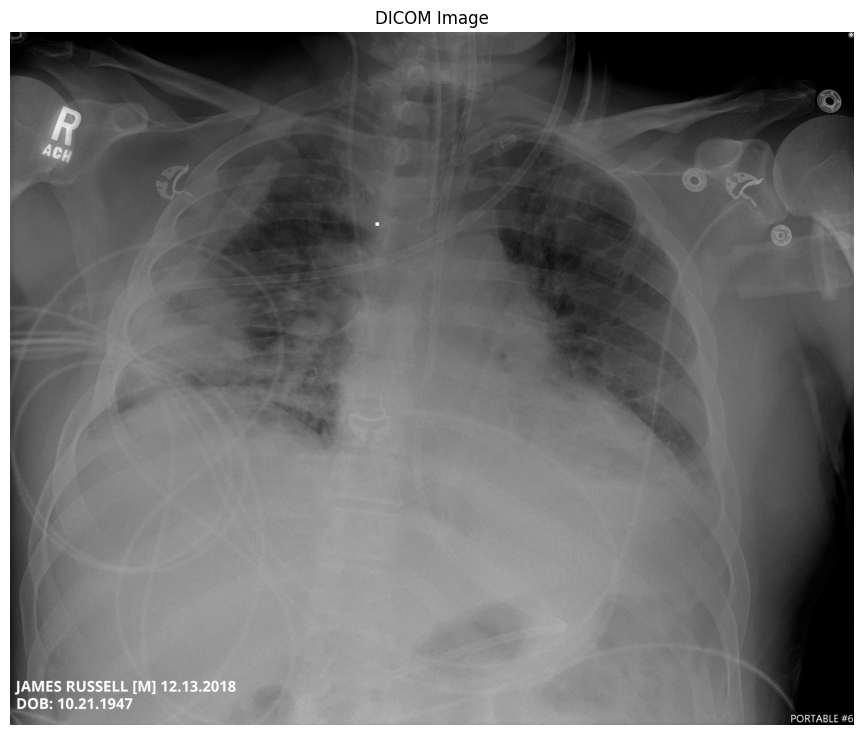

In [8]:
# dump tags before De-id
dump_object_to_text(processor.ds, '../temp/ds_after_de_id.txt')
# show med image before de-identification
draw_img(processor.image_data)

## Evaluate Redacted DICOM Metadata

In [9]:
from common.utils import dump_dict_to_tsv, get_date_time
detected_elements, tags, ids = processor.detect_id_in_tags()
if ids and len(ids) > 0:
    # print("Found PII/PHI in redacted DICOM: ", ids)
    # create a evaluation report
    eval_dict_list = []
    for i in range(len(ids)):
        eval_dict = {"tag": tags[i], "Detected PHI": ids[i]}
        eval_dict_list.append(eval_dict)
    dump_dict_to_tsv(eval_dict_list, f"../output/report/tags_de_id_evaluation_report_{get_date_time()}.tsv")
    # redact remaining PHI 
    processor.redact_tags(detected_elements)
    print("Remaining PHI information in de-identified DICOM metadata are redacted.")

else:
    print("No PII/PHI found in redacted DICOM")

No PII/PHI found in redacted DICOM


## Evaluate Redacted DICOM Pixel Data

In [10]:
# check after redacted
id_text_detected, text_detected = processor.detect_id_in_img(DESTINATION_BUCKET, src_key, True)
if id_text_detected and len(id_text_detected) > 0:
    print(f'Sensitive text detected in pixel in {local_de_id_dicom}')
    dump_dict_to_tsv(id_text_detected, f"../output/report/img_de_id_evaluation_report_{get_date_time()}.tsv")
    print (id_text_detected)
    processor.redact_id_in_image(id_text_detected)
else:
    print(f'No sensitive text detected in {dist_key}')

Entity: JAMES RUSSELL - Type: NAME - Confidence: 0.999751627445221
Entity: 12.13.2018 - Type: DATE - Confidence: 0.9673264026641846
Entity: 10.21.1947 - Type: DATE - Confidence: 0.9759356379508972
Entity: JAMES - Type: NAME - Confidence: 0.9852050542831421
Entity: RUSSELL - Type: NAME - Confidence: 0.9871007204055786
Entity: 12.13.2018 - Type: DATE - Confidence: 0.990911066532135
Entity: 10.21.1947 - Type: DATE - Confidence: 0.9674103856086731
Sensitive text detected in pixel in ../images/med_de_id_img/test/patient^0183/1.2.826.0.1.3680043.8.498.12372289320255216260030039034645098873/1.2.826.0.1.3680043.8.498.39192757444426073927643210240319308820/00000001.dcm
[{'Text': 'JAMES RUSSELL [M] 12.13.2018', 'Text Block': {'Left': 16.004494540393353, 'Top': 2611.875033378601, 'Width': 897.5652894973755, 'Height': 66.42528846859932}}, {'Text': 'DOB: 10.21.1947', 'Text Block': {'Left': 24.606023535132408, 'Top': 2687.890625, 'Width': 470.24848222732544, 'Height': 49.21875}}, {'Text': 'JAMES', '

## Update evaluated DICOM file if remaining PHI info detected and redacted

DICOM file has been saved to ../images/med_eval_img/00000001.dcm.
number_of_frames: 1
min_pixel: 0, max_pixel: 4095


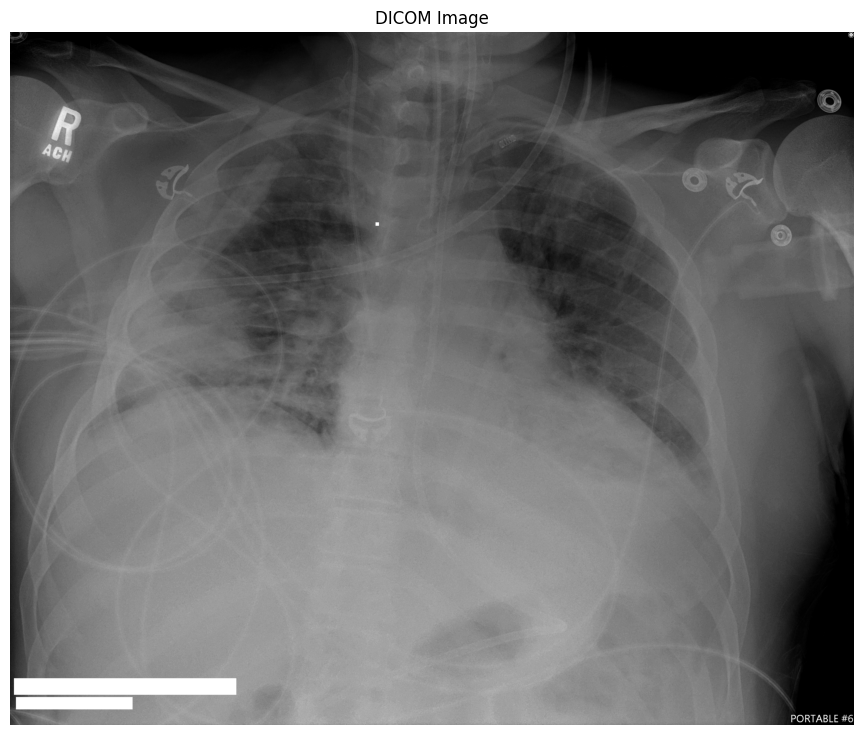

In [11]:
local_eval_dicom_dir =f"{LOC_EVAL_DICOM_FOLDER}test/{processor.patient_id}/{processor.studyInstanceUID}/{processor.seriesInstanceUID}/"
if not os.path.exists(local_eval_dicom_dir):
    os.makedirs(local_eval_dicom_dir)
local_eval_dicom = os.path.join(LOC_EVAL_DICOM_FOLDER, local_img_file)
processor.save_de_id_dicom(local_eval_dicom)
if (ids and len(ids) > 0) or (id_text_detected and len(id_text_detected) > 0):
    # show evaluated dicom
    result = processor.parse_dicom_file(None, None, local_eval_dicom)
    draw_img(processor.image_data)
    dump_object_to_text(processor.ds, '../temp/ds_after_eval.txt') 

## Self-learning: update rules for detecting PHI/PII information in DICOM file.

In [12]:
if ids and len(ids) > 0:
    processor.update_rules_in_configs(rule_config_file_path)

# close the processor
processor.close()

Completed!
